In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

import cv2
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [ ]:
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras.layers import AveragePooling2D,GlobalAveragePooling2D,Concatenate,Lambda
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam


In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/GAN')
df = pd.read_csv('/content/drive/MyDrive/GAN/data_dresses.csv',sep=';')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.head()


,id,img_path,attributes,brand,category,color,img_url,model_img_urls,name,product_url,sleeve_length,length,neckline,pattern,fit,occasion
0,05.803.82.8357_595932,dresses/05.803.82.8357_595932.jpg,"Normaler Träger, Rundhals-Ausschnitt, Taillier...",s.Oliver RED LABEL,dresses,black,https://cdn.aboutstatic.com/file/d34a04c09625b...,https://cdn.aboutstatic.com/file/be94104d68a1b...,Kleid,https://www.aboutyou.de/p/s-oliver-red-label/k...,short,knee,round,unicolors,tight,NaN
1,05.807.82.6853_46B132,dresses/05.807.82.6853_46B132.jpg,"Abgesteppter Saum/Kante, Ausgestellter Schnitt...",s.Oliver RED LABEL,dresses,pink,https://cdn.aboutstatic.com/file/8e2503d650365...,https://cdn.aboutstatic.com/file/89d75c9971649...,Kleid,https://www.aboutyou.de/p/s-oliver-red-label/k...,sleeveless,short,back,floral,tight,NaN
2,05.807.82.7936_59G332,dresses/05.807.82.7936_59G332.jpg,"Abgesteppter Saum/Kante, Ausgestellter Schnitt...",s.Oliver RED LABEL,dresses,blue,https://cdn.aboutstatic.com/file/cc792eac6cfd9...,https://cdn.aboutstatic.com/file/42b431d51042c...,Kleid,https://www.aboutyou.de/p/s-oliver-red-label/k...,short,short,deep,stripes,tight,NaN
3,100174,dresses/100174.jpg,"Damenkleid von Daniel Hechter, Leichtes Materi...",Daniel Hechter,dresses,black,https://img.fidcdn.net/r17/product/daniel-hech...,https://img.fidcdn.net/r17/product/daniel-hech...,Kleid mit Rundhalsausschnitt und kurzem Schlitz,https://www.fashionid.de/daniel-hechter/damen-...,NaN,NaN,NaN,NaN,loose,NaN
4,1001751002,dresses/1001751002.jpg,"Rundhals-Ausschnitt, Abgesteppter Saum/Kante, ...",TOM TAILOR DENIM,dresses,blue,https://cdn.aboutstatic.com/file/486c43af4548d...,https://cdn.aboutstatic.com/file/d22b4007739a0...,Kleid,https://www.aboutyou.de/p/tom-tailor-denim/kle...,long,3-4,round,NaN,normal,NaN


In [ ]:
df[df['color']== np.nan].shape

(0, 16)

In [ ]:
df['pattern'].unique()

array(['unicolors', 'floral', 'stripes', nan, 'print', 'lace',
       'polkadots'], dtype=object)

In [ ]:
#df = df.groupby(df['pattern']).head(500)

In [ ]:
df = df.dropna(axis=0, subset=['pattern'])
df = df.reset_index(drop=True)

In [ ]:
df.groupby(df['pattern']).count()

,id,img_path,attributes,brand,category,color,img_url,model_img_urls,name,product_url,sleeve_length,length,neckline,fit,occasion
pattern,,,,,,,,,,,,,,,
floral,2591,2591,2591,2591,2591,2591,2591,2590,2591,1471,2333,2213,1987,2514,807
lace,1018,1018,1018,1018,1018,1018,1018,1014,1018,535,795,568,771,918,574
polkadots,428,428,428,428,428,428,428,427,428,209,397,401,321,422,131
print,1220,1220,1220,1220,1220,1220,1220,1214,1220,519,1132,1198,928,1211,340
stripes,1010,1010,1010,1010,1010,1010,1010,1009,1010,582,862,808,772,953,164
unicolors,6098,6098,6098,6098,6098,6098,6098,6083,6098,3725,5710,6046,4738,6056,1477


In [ ]:
#shape = (200,200)  
images = []  
img_labels = []
for i in range(int(len(df))):
    img = cv2.imread(df['img_path'][i])
    #img = cv2.resize(img,shape)
    images.append(img)
    img_labels.append(df['pattern'][i])
    
    
labels = pd.get_dummies(img_labels).values    
labelname = pd.get_dummies(img_labels).columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12365 entries, 0 to 12364
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              12365 non-null  object
 1   img_path        12365 non-null  object
 2   attributes      12365 non-null  object
 3   brand           12365 non-null  object
 4   category        12365 non-null  object
 5   color           12365 non-null  object
 6   img_url         12365 non-null  object
 7   model_img_urls  12337 non-null  object
 8   name            12365 non-null  object
 9   product_url     7041 non-null   object
 10  sleeve_length   11229 non-null  object
 11  length          11234 non-null  object
 12  neckline        9517 non-null   object
 13  pattern         12365 non-null  object
 14  fit             12074 non-null  object
 15  occasion        3493 non-null   object
dtypes: object(16)
memory usage: 1.5+ MB


In [ ]:
len(np.array(img_labels))

12365

In [ ]:
dfc = pd.DataFrame({'key': np.array(img_labels),
                   'data': range(len(img_labels))}, columns=['key', 'data'])
dfc.groupby('key').count()


,data
key,
floral,2591
lace,1018
polkadots,428
print,1220
stripes,1010
unicolors,6098


(256, 256, 3)
(6,)
unicolors


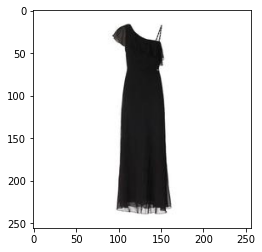

In [ ]:
imagenumber =100
print(images[imagenumber].shape)
#
print(labels[imagenumber].shape)
print(labelname[int(np.where(labels[imagenumber]==1)[0])])
RGB_img = cv2.cvtColor(images[imagenumber], cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)


In [ ]:
trlen = int(len(images)*0.75)
tslen = len(images)-trlen
print(trlen,tslen)


9273 3092


In [ ]:
trDat = images[:trlen]
trLbl = labels[:trlen]

tsDat = images[trlen:]
tsLbl = labels[trlen:]

trDat = np.array(trDat)
tsDat = np.array(tsDat)

In [ ]:
len(np.unique(img_labels))

6

In [ ]:
imgrows         = trDat[0].shape[0]
imgclms         = trDat[0].shape[1]
channel         = trDat[0].shape[2]
num_classes     = len(np.unique(img_labels))

In [ ]:
print(imgrows,imgclms,channel)

256 256 3


In [ ]:
optmz       = optimizers.RMSprop(lr=0.0001)                                     # Step 1


def createModel():
    inputs = Input(shape=(imgrows,imgclms,channel))
    x = Conv2D(32,(3,3),padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(32,(3,3),padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32,(3,3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(32,(3,3),padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64,(3,3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64,(3,3),padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128,(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128,(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(64,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x) 
    
    model = Model(inputs=inputs,outputs=x) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz, 
                  metrics=['accuracy'])


    return model

                                                                                # Step 4
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()                                                                 # Step 5

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 dropout (Dropout)           (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                             

In [ ]:
modelname       = 'pattern_pred_conv_5'                                                                                # Step 1
folderpath      = 'D:\\Intelligent Systems\\Pattern Recognition Systems\\PR-project\\jupytermodel\\'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=8, restore_best_weights=True)
csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger,early]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_conv_5.hdf5
Path to log:   D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_conv_5.csv


In [ ]:
history = model.fit(trDat,                    # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=50,                       # The amount of epochs to be trained
          batch_size=20,                   
          shuffle=True                     # To shuffle the training data
          ,callbacks=callbacks_list         # Callbacks to execute the checkpoints
         )

Epoch 1/50
464/464 [==============================] - 316s 682ms/step - loss: 1.6677 - accuracy: 0.5073 - val_loss: 1.7581 - val_accuracy: 0.5369
Epoch 2/50
464/464 [==============================] - 290s 625ms/step - loss: 1.3931 - accuracy: 0.6174 - val_loss: 1.4976 - val_accuracy: 0.5834
Epoch 3/50
464/464 [==============================] - 290s 625ms/step - loss: 1.2796 - accuracy: 0.6550 - val_loss: 1.4299 - val_accuracy: 0.6313
Epoch 4/50
464/464 [==============================] - 293s 632ms/step - loss: 1.2181 - accuracy: 0.6716 - val_loss: 1.3467 - val_accuracy: 0.6268
Epoch 5/50
464/464 [==============================] - 294s 634ms/step - loss: 1.1636 - accuracy: 0.6828 - val_loss: 1.2189 - val_accuracy: 0.6636
Epoch 6/50
464/464 [==============================] - 295s 636ms/step - loss: 1.1226 - accuracy: 0.6888 - val_loss: 1.3506 - val_accuracy: 0.6860
Epoch 7/50
464/464 [==============================] - 296s 639ms/step - loss: 1.0939 - accuracy: 0.6969 - val_loss: 1.1244 -

Text(0.5, 1.0, 'Accuracy evolution')

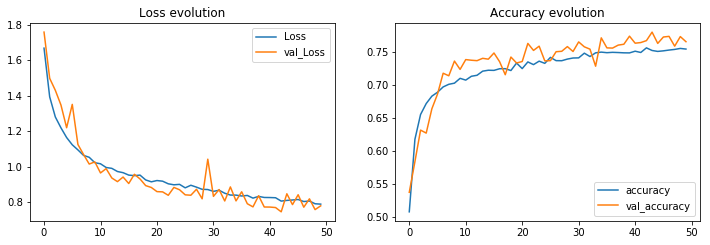

In [ ]:
#VIsualizing the training performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')

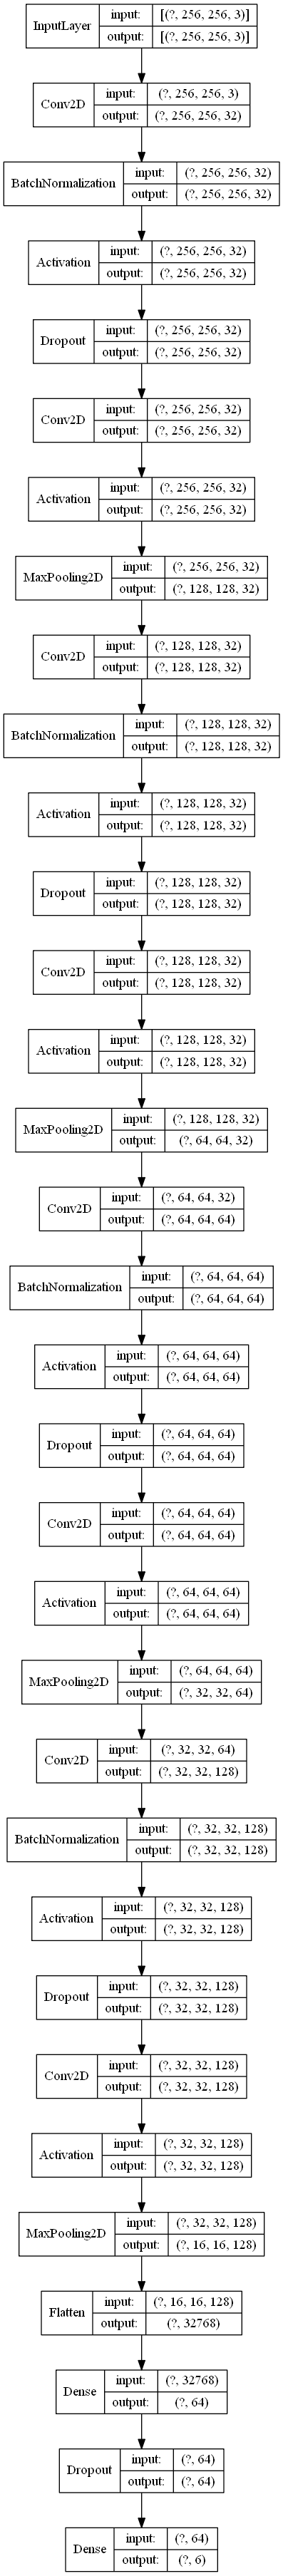

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           to_file='CNN_model5.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [ ]:
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(tsDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


In [ ]:
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 78.01%
              precision    recall  f1-score   support

      floral     0.7315    0.8490    0.7859       629
        lace     0.2609    0.1233    0.1674       146
   polkadots     0.5920    0.5968    0.5944       124
       print     0.4730    0.1070    0.1746       327
     stripes     0.8848    0.7967    0.8384       241
   unicolors     0.8306    0.9594    0.8903      1625

   micro avg     0.7801    0.7801    0.7801      3092
   macro avg     0.6288    0.5720    0.5752      3092
weighted avg     0.7404    0.7801    0.7433      3092



In [ ]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[ 534   10   15   17    3   50]
 [  24   18    0    2    3   99]
 [  14    0   74   13    0   23]
 [ 138    4   34   35   13  103]
 [   4    1    0    1  192   43]
 [  16   36    2    6    6 1559]]


In [ ]:
modelname       = 'pattern_pred_conv_5_model'                                                                                # Step 1
folderpath      = 'D:\\Intelligent Systems\\Pattern Recognition Systems\\PR-project\\jupytermodel\\'
filepath        = folderpath + modelname + ".hdf5"
model.save(filepath)

In [ ]:
optmz       = optimizers.RMSprop(lr=0.0001)                           

def createModel():
    inputs = Input(shape=(imgrows,imgclms,channel))
    x = Conv2D(32,(3,3),padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    y = x
    x = Conv2D(32,(3,3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = add([x,y])
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32,(3,3),padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64,(3,3),padding='same')(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    y = x
    x = Conv2D(64,(3,3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = add([x,y])
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(128,(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128,(3,3),padding='same',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(64,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax')(x) 
    
    model = Model(inputs=inputs,outputs=x) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optmz, 
                  metrics=['accuracy'])


    return model

                                                                                # Step 4
model_1       = createModel() # This is meant for training
modelGo_1     = createModel() # This is used for final testing

model_1.summary()                                                                 # Step 5

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 256, 256, 32) 128         conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 256, 256, 32) 0           batch_normalization_16[0][0]     
____________________________________________________________________________________________

In [ ]:
modelname       = 'pattern_pred_convres_5'                                                                                # Step 1
folderpath      = 'D:\\Intelligent Systems\\Pattern Recognition Systems\\PR-project\\jupytermodel\\'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=8, restore_best_weights=True)
csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger,early]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_convres_5.hdf5
Path to log:   D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_convres_5.csv


In [ ]:
history_1 = model_1.fit(trDat,                    # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=25,                       # The amount of epochs to be trained
          batch_size=20,                   
          shuffle=True                     # To shuffle the training data
          ,callbacks=callbacks_list         # Callbacks to execute the checkpoints
         )

Epoch 1/25
464/464 [==============================] - 388s 835ms/step - loss: 1.6001 - accuracy: 0.5479 - val_loss: 1.4612 - val_accuracy: 0.6756
Epoch 2/25
464/464 [==============================] - 401s 864ms/step - loss: 1.3148 - accuracy: 0.6429 - val_loss: 1.2296 - val_accuracy: 0.7054
Epoch 3/25
464/464 [==============================] - 371s 800ms/step - loss: 1.2315 - accuracy: 0.6653 - val_loss: 1.2841 - val_accuracy: 0.6882
Epoch 4/25
464/464 [==============================] - 428s 923ms/step - loss: 1.1665 - accuracy: 0.6777 - val_loss: 1.2512 - val_accuracy: 0.7329
Epoch 5/25
464/464 [==============================] - 460s 992ms/step - loss: 1.1359 - accuracy: 0.6916 - val_loss: 1.3695 - val_accuracy: 0.7215
Epoch 6/25
464/464 [==============================] - 423s 911ms/step - loss: 1.0936 - accuracy: 0.6955 - val_loss: 1.4038 - val_accuracy: 0.6387
Epoch 7/25
464/464 [==============================] - 328s 706ms/step - loss: 1.0725 - accuracy: 0.7013 - val_loss: 1.1085 -

Text(0.5, 1.0, 'Accuracy evolution')

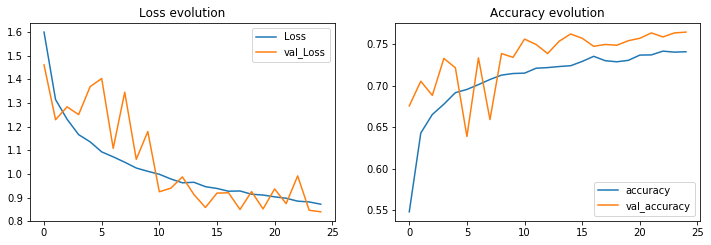

In [ ]:
#VIsualizing the training performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_1.history['loss'], label='Loss')
plt.plot(history_1.history['val_loss'], label='val_Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')

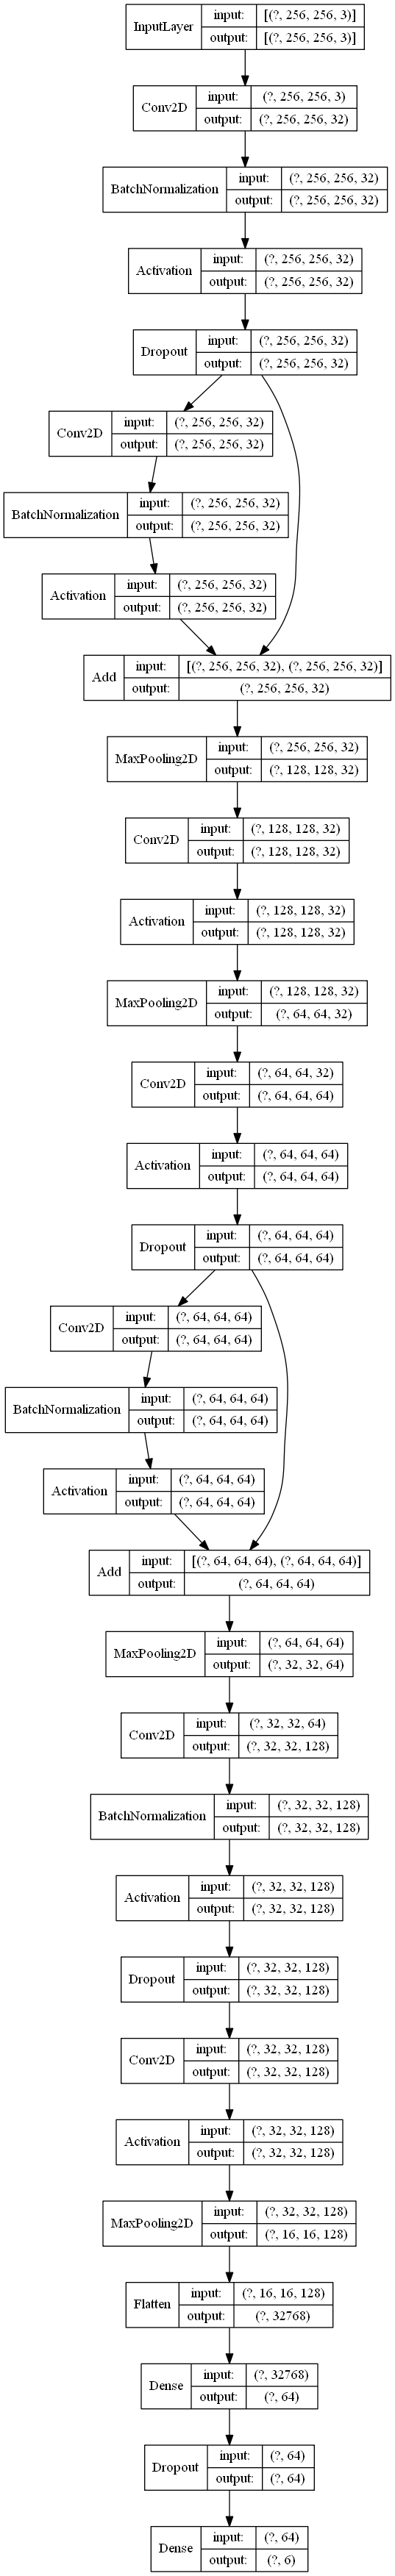

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, 
           to_file='CNNres_model5.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [ ]:
modelGo_1.load_weights(filepath)
modelGo_1.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo_1.predict(tsDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


In [ ]:
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                        

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 76.46%
              precision    recall  f1-score   support

      floral     0.6743    0.8458    0.7504       629
        lace     0.1739    0.0274    0.0473       146
   polkadots     0.7292    0.2823    0.4070       124
       print     0.6957    0.0489    0.0914       327
     stripes     0.9375    0.7469    0.8314       241
   unicolors     0.7918    0.9828    0.8770      1625

   micro avg     0.7646    0.7646    0.7646      3092
   macro avg     0.6670    0.4890    0.5007      3092
weighted avg     0.7374    0.7646    0.7066      3092



In [ ]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[ 532    8    3    3    3   80]
 [  19    4    0    0    3  120]
 [  44    0   35    4    0   41]
 [ 172    2   10   16    6  121]
 [   3    0    0    0  180   58]
 [  19    9    0    0    0 1597]]


In [ ]:
#optmz       = optimizers.RMSprop(lr=0.0002)                                     # Step 1
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):

    convLyr     = Conv2D(numFilters,
                         kernel_size=kernelSz,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4),
                         name=lyrName+'_conv' if lyrName else None)
    x           = inputs
    
    if convFirst:
        x       = convLyr(x)
        
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
            
        x       = convLyr(x)
    return x

                                                                                # Step 4
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    
    x       = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr  = str(run+1)
        
        if downsampleOnFirst and run == 0:
            strides     = 2
            
        y       = resLyr(inputs=x,
                         numFilters=numFilters,
                         strides=strides,
                         lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y       = resLyr(inputs=y,
                         numFilters=numFilters,
                         activation=None,
                         lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x   = resLyr(inputs=x,
                         numFilters=numFilters,
                         kernelSz=1,
                         strides=strides,
                         activation=None,
                         batchNorm=False,
                         lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x       = add([x,y],
                      name=names+'_Blk'+blkStr+'_add' if names else None)
        x       = Activation('relu',
                             name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
        
    return x
    
                                                                                # Step 5
def createResNetV1(inputShape=(imgrows,imgclms,channel), numClasses=num_classes):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs,lyrName='Inpt')
    v = resBlkV1(inputs=v,numFilters=16,numBlocks=3,downsampleOnFirst=False,names='Stg1')
    v = resBlkV1(inputs=v,numFilters=32,numBlocks=3,downsampleOnFirst=True,names='Stg2')
    v = resBlkV1(inputs=v,numFilters=64,numBlocks=3,downsampleOnFirst=True,names='Stg4')
    v = AveragePooling2D(pool_size=4,name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses,activation='softmax',kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']) 

    return model

                                                                                # Step 6
model_2       = createResNetV1()  # This is meant for training
modelGo_2     = createResNetV1()  # This is used for final testing

model_2.summary()                                                                 # Step 7

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 256, 256, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 256, 256, 16) 64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 256, 256, 16) 0           Inpt_bn[0][0]                    
____________________________________________________________________________________________

In [ ]:
modelname       = 'pattern_pred_resnet1'                                                                                # Step 1
folderpath      = 'D:\\Intelligent Systems\\Pattern Recognition Systems\\PR-project\\jupytermodel\\'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_resnet1.hdf5
Path to log:   D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_resnet1.csv


In [ ]:
history_2 = model_2.fit(trDat,                    # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=10,                       # The amount of epochs to be trained
          batch_size=16,                   
          shuffle=True                     # To shuffle the training data
          ,callbacks=callbacks_list         # Callbacks to execute the checkpoints
         )

Epoch 1/10
580/580 [==============================] - 1174s 2s/step - loss: 1.0888 - accuracy: 0.6873 - val_loss: 1.0601 - val_accuracy: 0.7403
Epoch 2/10
580/580 [==============================] - 845s 1s/step - loss: 0.9960 - accuracy: 0.7153 - val_loss: 1.0244 - val_accuracy: 0.7432
Epoch 3/10
580/580 [==============================] - 820s 1s/step - loss: 0.9249 - accuracy: 0.7361 - val_loss: 1.0581 - val_accuracy: 0.6666
Epoch 4/10
580/580 [==============================] - 835s 1s/step - loss: 0.8551 - accuracy: 0.7514 - val_loss: 0.9778 - val_accuracy: 0.7299
Epoch 5/10
580/580 [==============================] - 2042s 4s/step - loss: 0.7964 - accuracy: 0.7670 - val_loss: 0.9960 - val_accuracy: 0.7500
Epoch 6/10
580/580 [==============================] - 3313s 6s/step - loss: 0.7369 - accuracy: 0.7887 - val_loss: 0.8756 - val_accuracy: 0.7435
Epoch 7/10
580/580 [==============================] - 3861s 7s/step - loss: 0.6676 - accuracy: 0.8101 - val_loss: 0.9327 - val_accuracy: 0.

Text(0.5, 1.0, 'Accuracy evolution')

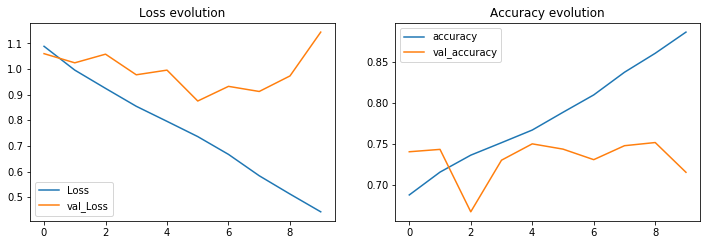

In [ ]:
#VIsualizing the training performance
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_2.history['loss'], label='Loss')
plt.plot(history_2.history['val_loss'], label='val_Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')

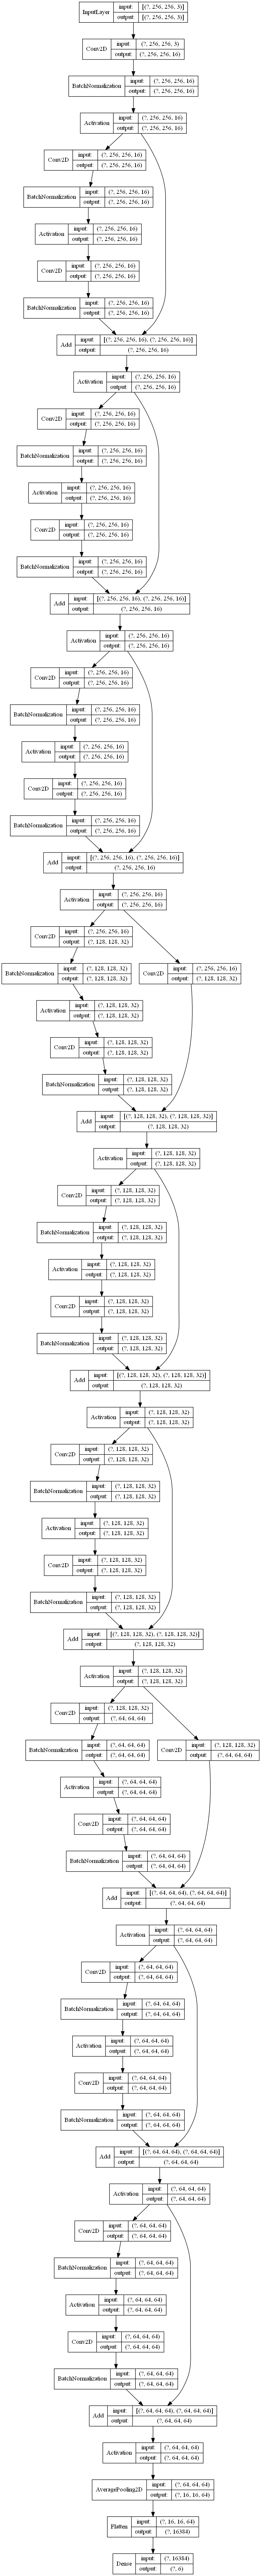

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, 
           to_file='CNNresnet_model5.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [ ]:
modelGo_2.load_weights(filepath)
modelGo_2.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo_2.predict(tsDat)                                            # Step 2
print("Prediction completes.")

In [ ]:
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 75.16%
              precision    recall  f1-score   support

      floral     0.7266    0.7901    0.7570       629
        lace     0.1984    0.1712    0.1838       146
   polkadots     0.5612    0.4435    0.4955       124
       print     0.3716    0.1682    0.2316       327
     stripes     0.8169    0.7220    0.7665       241
   unicolors     0.8327    0.9342    0.8805      1625

   micro avg     0.7516    0.7516    0.7516      3092
   macro avg     0.5846    0.5382    0.5525      3092
weighted avg     0.7203    0.7516    0.7295      3092



In [ ]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[ 497   31   12   37    4   48]
 [  17   25    2    5    1   96]
 [  19    6   55   25    2   17]
 [ 128    8   25   55   14   97]
 [   4    1    1   14  174   47]
 [  19   55    3   12   18 1518]]


In [ ]:
###Convolutional Block
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
    x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
    x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
    if act:
        x = Activation('relu',name=name+'conv2d'+'act')(x)
    return x

##Inception ResNet A block
def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay


##Stem block
img_input = Input(shape=(imgrows,imgclms,channel))

x = conv2d(img_input,32,3,2,'valid',True,name='conv1')
x = conv2d(x,32,3,1,'valid',True,name='conv2')
x = conv2d(x,64,3,1,'valid',True,name='conv3')

x_11 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,64,3,1,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])


##Inception-ResNet Network
x = incresA(x,0.15,name='incresA_1')

#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)
x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')
x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])


#TOP
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
x = Dense(num_classes, activation='softmax')(x)


In [ ]:
model_3 = Model(img_input,x,name='inception_resnet_v2')

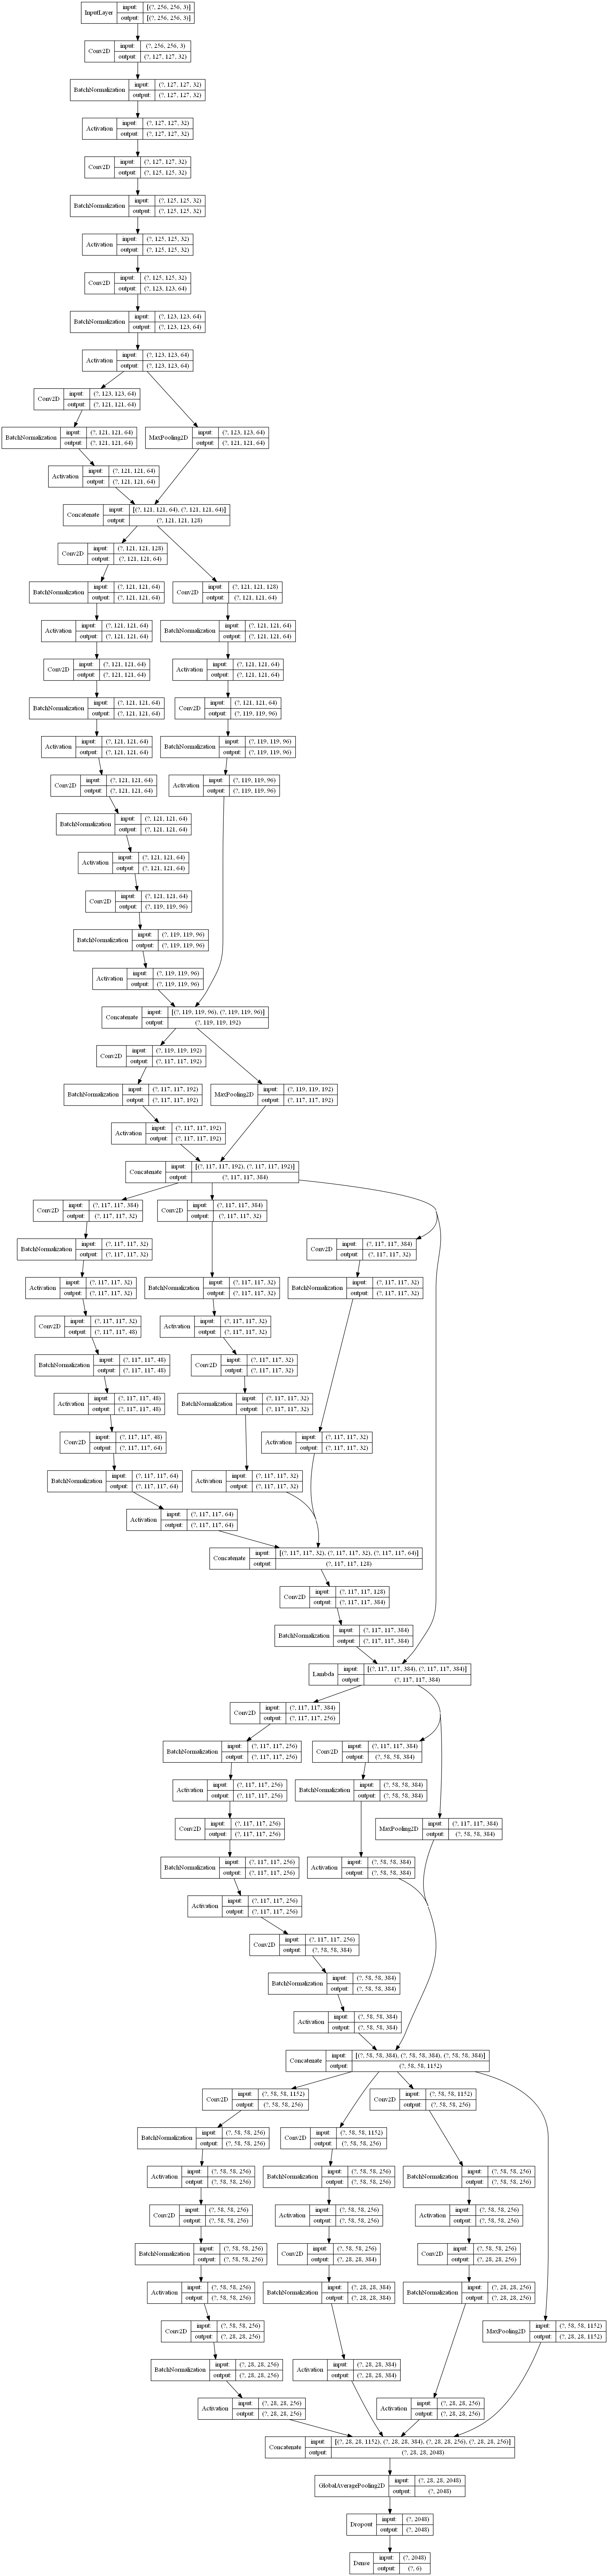

In [ ]:
plot_model(model_3, 
           to_file='inception_resnet_v2.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

In [ ]:
model_3.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1conv2d (Conv2D)            (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
conv1conv2dbn (BatchNormalizati (None, 127, 127, 32) 96          conv1conv2d[0][0]                
__________________________________________________________________________________________________
conv1conv2dact (Activation)     (None, 127, 127, 32) 0           conv1conv2dbn[0][0]              
________________________________________________________________________________

In [ ]:
model_3.compile(Adam(lr=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
modelGo_3 = Model(img_input,x,name='inception_resnet_v2')
modelGo_3.compile(Adam(lr=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
modelname       = 'pattern_pred_inceptionresnet_5'                                                                                # Step 1
folderpath      = 'D:\\Intelligent Systems\\Pattern Recognition Systems\\PR-project\\jupytermodel\\'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
#callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4, restore_best_weights=True)
callbacks_list = [checkpoint, early,csv_logger]
print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')




Callbacks created:

Path to model: D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_inceptionresnet_5.hdf5
Path to log:   D:\Intelligent Systems\Pattern Recognition Systems\PR-project\jupytermodel\pattern_pred_inceptionresnet_5.csv


In [ ]:
history_3 = model_3.fit(trDat,                    # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=5,                       # The amount of epochs to be trained
          batch_size=5,                   
          shuffle=True                     # To shuffle the training data
          ,callbacks=callbacks_list         # Callbacks to execute the checkpoints
         )

Epoch 1/5
1855/1855 [==============================] - 5449s 3s/step - loss: 1.2155 - accuracy: 0.6143 - val_loss: 0.8413 - val_accuracy: 0.7477
Epoch 2/5
1855/1855 [==============================] - 7543s 4s/step - loss: 1.0483 - accuracy: 0.6599 - val_loss: 1.0195 - val_accuracy: 0.7002
Epoch 3/5
1855/1855 [==============================] - 6180s 3s/step - loss: 0.9830 - accuracy: 0.6778 - val_loss: 0.8010 - val_accuracy: 0.7484
Epoch 4/5
1855/1855 [==============================] - 6249s 3s/step - loss: 0.9510 - accuracy: 0.6825 - val_loss: 0.8720 - val_accuracy: 0.7183
Epoch 5/5
1855/1855 [==============================] - 5817s 3s/step - loss: 0.9234 - accuracy: 0.6942 - val_loss: 1.2706 - val_accuracy: 0.5249


Text(0.5, 1.0, 'Accuracy evolution')

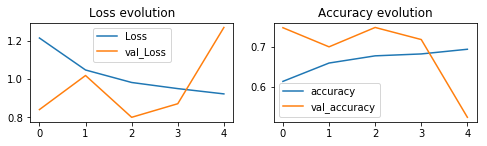

In [ ]:
#VIsualizing the training performance
plt.figure(figsize=(8, 4))

plt.subplot(2, 2, 1)
plt.plot(history_3.history['loss'], label='Loss')
plt.plot(history_3.history['val_loss'], label='val_Loss')
plt.legend()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy evolution')

In [ ]:
modelGo_3 = Model(img_input,x,name='inception_resnet_v2')
modelGo_3.load_weights(filepath)
modelGo_3.compile(loss='categorical_crossentropy', 
                optimizer='Adam', 
                metrics=['accuracy'])

predicts    = modelGo_3.predict(tsDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


In [ ]:
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 74.84%
              precision    recall  f1-score   support

      floral     0.6903    0.7901    0.7368       629
        lace     0.0000    0.0000    0.0000       146
   polkadots     0.5043    0.4677    0.4854       124
       print     0.3158    0.1651    0.2169       327
     stripes     0.9416    0.5353    0.6825       241
   unicolors     0.8086    0.9698    0.8819      1625

   micro avg     0.7484    0.7484    0.7484      3092
   macro avg     0.5434    0.4880    0.5006      3092
weighted avg     0.6924    0.7484    0.7090      3092



C:\Users\DELL\anaconda3\envs\cogsys\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)